In [ ]:
%load_ext autoreload
%autoreload 2

# Bike number of spots prediction EDA

**Objective**: Predict the minimum number of spots available by station, hour and date from April to November.

This notebook's purpose is to conduct a Exploratory Data Analysis (EDA) for both historical bixi rides and weather data. Some of the questions we are looking for are the following:

- Loadining data and cleaning data
    - Standarize stations names
- How many bixi stations exist ?
- What are the number of average rides per day of the week, month and hour of the day ?
- Explore the most popular stations and rides
- What are the number of average available spots day of the week, month and hour of the day ?
- Explore weather data
- How does the number of rides correlate with weather (i.e precipiation, temperature, sunnny days) ?

**For simplicity, we'll perform the subsequent analysis using data obatined by running the developed** `RidesDataPipeline` **for years 2023 to 2024**

In [7]:
# declaring dependencies
from pandas import Series, merge, read_csv, to_datetime, Grouper
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import unicodedata
from utils import standarize_station_name
from bixi_availability_prediction.etl import get_stations_capacity
from constants import STATION_CAPACITY_URL

## Loadining data and cleaning data

In order to proceed with the subsequent steps, we'll first load the historical rides data and perform some general cleanining steps

In [2]:
hist_rides=read_csv('historical_rides_data_2023_to_2024.csv')

In [3]:
# setting column for ride number
# to facilitate grouping operations
hist_rides['RIDE'] = 1

In [4]:
# enforcing datatime data type
hist_rides = hist_rides.assign(
    start_date=to_datetime(hist_rides['start_date']),
    end_date=to_datetime(hist_rides['end_date'])
)

In [5]:
hist_rides.head()

,Unnamed: 0,start_date,end_date,name_start_station,name_end_station,latitude_start_station,longitude_start_station,latitude_end_station,longitude_end_station,RIDE
0,0,2023-10-25 20:44:56.468,2023-10-25 20:51:32.113,Métro Mont-Royal (Utilités publiques / Rivard),Chabot / Mont-Royal,45.524236,-73.581552,45.534134,-73.573524,1
1,1,2023-10-25 21:48:55.502,2023-10-25 22:12:47.951,Rielle / Wellington,St-Jacques / McGill,45.460156,-73.567001,45.501441,-73.560144,1
2,2,2023-10-26 02:01:45.974,2023-10-26 02:06:32.418,Ste-Catherine / Drummond,Peel / Ottawa,45.498588,-73.574278,45.494200,-73.559985,1
3,3,2023-10-25 21:31:29.932,2023-10-25 21:36:54.383,Boyer / du Mont-Royal,de l'Hôtel-de-Ville / Rachel,45.527432,-73.579917,45.519897,-73.580106,1
4,4,2023-10-25 21:40:06.571,2023-10-25 21:47:20.298,Clark / Ontario,Wolfe / Robin,45.510625,-73.566903,45.519581,-73.560116,1


### Standarize stations names

Station names are not standard overtime. For example, for certain years, non-ASCII are present while is not for others. The same happens with spaces and casining. Therefore, a utility function to standarize the name need to be developed and subsequently applied on rides/statations capacity datasets.

One factor to consider when designing this function is the size of the rides data. There are millions of rows for a single year which could be problematic if we were to apply the standarization for each line even considerining the use of vectorized functions. Hence, our approach will to first indetify the unique station names, apply the standarization, create a dictionary for reference and then apply that dictionary to the original pandas series.

In [6]:
def standarize_station_name(series: Series) -> Series:
    """
    Remove non-ASCII charcaters, lowercase and strip station name
    """

    unique_stations = series.unique()
    cleaned_station_names = {
        station: (
            station.encode('ascii', 'ignore')
            .decode('ascii')
            .lower()
            .replace(' ', '')
            .replace('/', '_')
            .strip()
        )
        for station in unique_stations
    }

    return Series(
        cleaned_station_names[station] 
        for station in series
    )

In [8]:
# cleaning station names
hist_rides = hist_rides.dropna(subset=['name_start_station','name_end_station'])
hist_rides['name_start_station'] = standarize_station_name(hist_rides['name_start_station'])
hist_rides['name_end_station'] = standarize_station_name(hist_rides['name_end_station'])

## How many bixi stations exist ?

In [9]:
len(hist_rides['name_start_station'].unique())

1232

After removing the duplicates, we can observe that there are around 1200 unique stations in Montreal

## What are the number of average rides per day of the week, month and hour of the day ?

In [11]:
hist_rides.head()

,Unnamed: 0,start_date,end_date,name_start_station,name_end_station,latitude_start_station,longitude_start_station,latitude_end_station,longitude_end_station,RIDE
0,0,2023-10-25 20:44:56.468,2023-10-25 20:51:32.113,mtromont-royal(utilitspubliques_rivard),chabot_mont-royal,45.524236,-73.581552,45.534134,-73.573524,1
1,1,2023-10-25 21:48:55.502,2023-10-25 22:12:47.951,rielle_wellington,st-jacques_mcgill,45.460156,-73.567001,45.501441,-73.560144,1
2,2,2023-10-26 02:01:45.974,2023-10-26 02:06:32.418,ste-catherine_drummond,peel_ottawa,45.498588,-73.574278,45.494200,-73.559985,1
3,3,2023-10-25 21:31:29.932,2023-10-25 21:36:54.383,boyer_dumont-royal,del'htel-de-ville_rachel,45.527432,-73.579917,45.519897,-73.580106,1
4,4,2023-10-25 21:40:06.571,2023-10-25 21:47:20.298,clark_ontario,wolfe_robin,45.510625,-73.566903,45.519581,-73.560116,1


In [13]:
hist_rides.groupby(Grouper(key='start_date', freq='D'))['RIDE'].sum().reset_index()

,start_date,RIDE
0,2023-04-12,7034
1,2023-04-13,31630
2,2023-04-14,42935
3,2023-04-15,52882
4,2023-04-16,52548
...,...,...
626,2024-12-28,1438
627,2024-12-29,1388
628,2024-12-30,2319
629,2024-12-31,2910


<Axes: xlabel='start_date', ylabel='RIDE'>

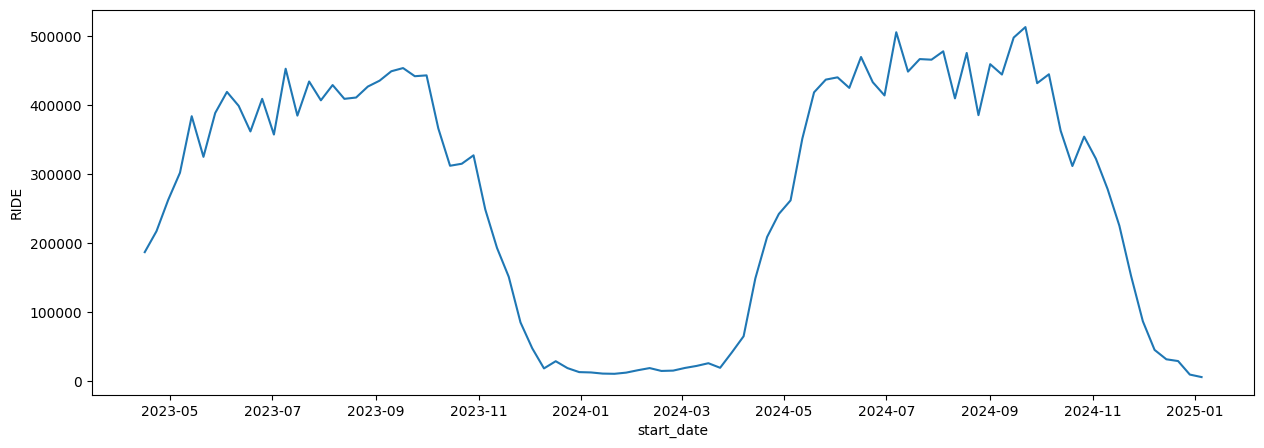

In [15]:
# let's first check the overall trend
# plotting number of rides per week sep
fig, axes = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x='start_date', 
    y='RIDE', 
    data=hist_rides.groupby(Grouper(key='start_date', freq='W'))['RIDE'].sum().reset_index()
)

In [ ]:
# extracting time parameters for aggregations
hist_rides['MONTH'] = hist_rides['start_date'].dt.month
hist_rides['WEEK_DAY'] = hist_rides['start_date'].dt.weekday
hist_rides['START_HOUR'] = hist_rides['start_date'].dt.hour
hist_rides['END_HOUR'] = hist_rides['end_date'].dt.hour
hist_rides['WEEK_OF_YEAR'] = hist_rides['start_date'].dt.isocalendar().week

In [ ]:
# mask for april to november
mask = hist_rides['MONTH'].between(4,11)

In [ ]:
# performing desired aggregations
agg_by_month = hist_rides[mask]['MONTH'].value_counts(normalize=True).reset_index()
agg_by_weekday = hist_rides[mask]['WEEK_DAY'].value_counts(normalize=True).reset_index()
agg_by_start_hour = hist_rides[mask]['START_HOUR'].value_counts(normalize=True).reset_index()
agg_by_end_hour = hist_rides[mask]['END_HOUR'].value_counts(normalize=True).reset_index()

In [ ]:
# plotting aggregations
fig, axes = plt.subplots(2, 2, figsize=(25, 15))

sns.barplot(x='MONTH', y='proportion', data=agg_by_month, ax=axes[0][0])
sns.barplot(x='WEEK_DAY', y='proportion', data=agg_by_weekday, ax=axes[0][1])
sns.barplot(x='START_HOUR', y='proportion', data=agg_by_start_hour, ax=axes[1][0])
sns.barplot(x='END_HOUR', y='proportion', data=agg_by_end_hour, ax=axes[1][1])
sns.barplot(x='END_HOUR', y='proportion', data=agg_by_end_hour, ax=axes[1][1])

axes[0][0].set_title('Proportion of rides per Month')
axes[0][1].set_title('Proportion of rides per Week Day')
axes[1][0].set_title('Proportion of rides per Ride Start Hour')
axes[1][1].set_title('Proportion of rides per Ride End Hour')

Based on the charts above, it's possible to state the following:
* July to September (not susprisingly given the warmer weather) are the months with the highest number of rides which decrease sharply after October,
* Riders tend to perfer to ride the most on Fridays and Saturdays and the least on Mondays.
* The number of rides increases sharply from 9AM to 9PM and decreases substentialy from 10PM to 8AM for both departures and arrivals at stations

## Explore the most popular stations and rides

In [ ]:
# most popular departure stations
agg_by_start_station = hist_rides['name_start_station'].value_counts(normalize=True).reset_index()
agg_by_start_station['CUM_PROPORTIONS'] = agg_by_start_station['proportion'].cumsum()
agg_by_start_station.head(1000)

80% of the departures tend to occur within 500 stations

In [ ]:
# most popular arrival stations neighbordhood
agg_by_end_station = hist_rides['name_end_station'].value_counts(normalize=True).reset_index()
agg_by_end_station['CUM_PROPORTIONS'] = agg_by_end_station['proportion'].cumsum()
agg_by_end_station.head(1000)

The end stations follows the same patterns as the departure ones

In [ ]:
# checking the most popular ride routes
agg_by_route = (
    hist_rides[['name_start_station','name_end_station']]
    .value_counts(normalize=True)
    .reset_index()
)
agg_by_route['CUM_PROPORTIONS'] = agg_by_route['proportion'].cumsum()
agg_by_route['CIRCULAR_RIDE_FLAG'] = agg_by_route.apply(
    lambda row: 1 if row['name_start_station'] == row['name_end_station'] else 0, axis=1
)

In [ ]:
# number of unique rides
agg_by_route.shape[0]

In [ ]:
agg_by_route

In [ ]:
hist_rides['CIRCULAR_RIDE_FLAG'] = hist_rides.apply(
    lambda row: 1 if row['name_start_station'] == row['ENDSTATIONNAME'] else 0, axis=1
)

In [ ]:
# checking for circular rides (start and end stations are the same)
agg_by_circular_routes = (
    hist_rides['CIRCULAR_RIDE_FLAG']
    .value_counts(normalize=True)
    .reset_index()
)

In [ ]:
agg_by_circular_routes

There around 583 k different rides that take place within the 165 bixi stations. Of those, only 4% are cicular (start and end station are the same)

## What are the number of average available spots day of the week, month and hour of the day ?

Our target variable is number of bikes available per station and not number of trips as pervioulsy explored. Thus, it's necessary to calculate our target varibale overtime as there is not historical information on this. The only data availabe is, unfortunately, the live one provided by Bixi through an API.

In [ ]:
# importining station capacity and cleaning station name
stations_capacity = get_stations_capacity(STATION_CAPACITY_URL)
stations_capacity['station_name'] = standarize_station_name(stations_capacity['station_name'])

In [ ]:
hist_rides['MONTH'] = hist_rides['start_date'].dt.month
hist_rides['WEEK_DAY'] = hist_rides['start_date'].dt.weekday
hist_rides['START_HOUR'] = hist_rides['start_date'].dt.hour
hist_rides['END_HOUR'] = hist_rides['end_date'].dt.hour

## Explore weather data